In [3]:
import tensorflow as tf
import numpy as np
from tensorflow_vgg.utils import load_image, print_prob
from nbutil import imshow_multi, to_pil
import random
import scipy

In [7]:
graph = tf.Graph()
session = tf.InteractiveSession(graph=graph)
model = '../data/tensorflow_inception_graph.pb'
with tf.gfile.FastGFile(model, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input': t_preprocessed})

In [19]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]
print layers

[u'import/conv2d0_pre_relu/conv', u'import/conv2d1_pre_relu/conv', u'import/conv2d2_pre_relu/conv', u'import/mixed3a_1x1_pre_relu/conv', u'import/mixed3a_3x3_bottleneck_pre_relu/conv', u'import/mixed3a_3x3_pre_relu/conv', u'import/mixed3a_5x5_bottleneck_pre_relu/conv', u'import/mixed3a_5x5_pre_relu/conv', u'import/mixed3a_pool_reduce_pre_relu/conv', u'import/mixed3b_1x1_pre_relu/conv', u'import/mixed3b_3x3_bottleneck_pre_relu/conv', u'import/mixed3b_3x3_pre_relu/conv', u'import/mixed3b_5x5_bottleneck_pre_relu/conv', u'import/mixed3b_5x5_pre_relu/conv', u'import/mixed3b_pool_reduce_pre_relu/conv', u'import/mixed4a_1x1_pre_relu/conv', u'import/mixed4a_3x3_bottleneck_pre_relu/conv', u'import/mixed4a_3x3_pre_relu/conv', u'import/mixed4a_5x5_bottleneck_pre_relu/conv', u'import/mixed4a_5x5_pre_relu/conv', u'import/mixed4a_pool_reduce_pre_relu/conv', u'import/mixed4b_1x1_pre_relu/conv', u'import/mixed4b_3x3_bottleneck_pre_relu/conv', u'import/mixed4b_3x3_pre_relu/conv', u'import/mixed4b_5x5_b

(512, 512, 3)


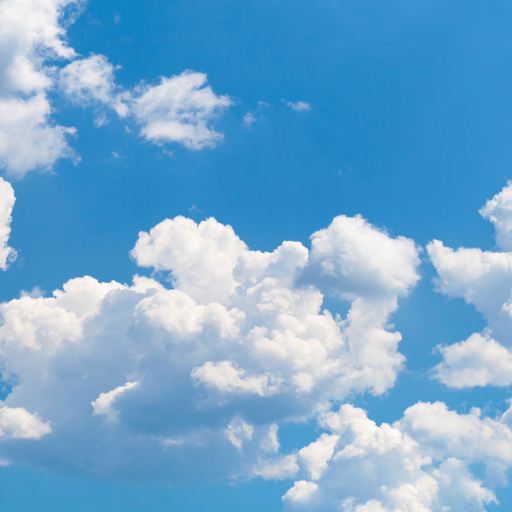

In [66]:
content_image = load_image('../data/clouds.jpg', size=512)# size=None for full size
# content_image = np.random.uniform(size=[512,512,3])


print content_image.shape
# content_layer = vgg.conv5_4[0]
# session.run(image.assign(content_image))
# content_layer.get_shape()
# content_layer_activations = session.run(content_layer)
to_pil(content_image)

In [12]:
def resize(img, size):
    h,w = size
    scale = [h * 1.0 / img.shape[0], w * 1.0 / img.shape[1], 1]
    # print scale
    result = scipy.ndimage.zoom(img, scale)
    # print result.shape[:2], (h,w)
    assert result.shape[:2] == (h,w)
    return result

# to_pil(resize(content_image, [1024, 1024]))

0
1
2
3


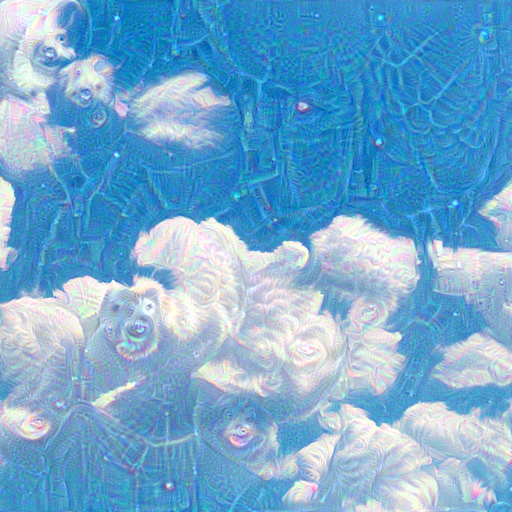

In [70]:
%matplotlib inline

# from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            h,w = sub.shape[:2]
            sub_padded = np.pad(sub, [(0, 512 - h), (0, 512 - w), (0, 0)], 'edge')
            g = session.run(t_grad, {t_preprocessed: np.array([sub_padded])})[:,:h,:w,:]
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

def dream(image, layer, channel, steps=20, step_size=1.5, octaves=4, octave_scale=1.5):
    image = image * 255
    gradient = tf.gradients(tf.reduce_mean(layer[0,:,:,channel]), [t_preprocessed])[0]
    
    hi_freq_images = []
    for octave in xrange(octaves - 1):
        new_size = (int(image.shape[0] / octave_scale), int(image.shape[1] / octave_scale))
        lo = resize(image, new_size)
        hi = image - resize(lo, image.shape[:2])
        hi_freq_images.append(hi)
        image = lo
    # now image is small, and hi_freq_images is a list of increasingly large images containing the high frequencies
    
    for i in xrange(octaves):
        print i
        if i > 0:
            hi = hi_freq_images[-i]
            image = resize(image, hi.shape[:2]) + hi
        for j in xrange(steps):
            # print i,j
            h,w = image.shape[:2]
            # image_padded = np.pad(image, [(0, 512 - h), (0, 512 - w), (0, 0)], 'edge')
            # g = session.run(gradient, {image_placeholder: np.array([image_padded])})[0,:h,:w]
            g = calc_grad_tiled(image, gradient)
            image += g * step_size / (np.abs(g).mean() + 0.0001)
    return image / 255

# import/mixed5b_5x5_pre_relu/conv:0
# mixed4d_3x3_bottleneck_pre_relu
# mixed5a_5x5_bottleneck_pre_relu/conv
layer = graph.get_tensor_by_name('import/mixed5a_5x5_bottleneck_pre_relu/conv:0')
# images = [dream(content_image, layer, channel) for channel in [0,1,2,3]]
# imshow_multi(images)
d = dream(content_image, layer, 14)
to_pil(d)